<a href="https://colab.research.google.com/github/filmerxyz/GarbageClassification/blob/master/Garbage_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Split Folders

In [ ]:
!pip install split-folders

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import shutil
import os
from os.path import join

import split_folders

from garbage_utils import *

# Hyperparameters

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

BATCH_SIZE = 32

LR = 3e-5

EPOCHS = 30

# Data

In [ ]:
!git clone https://github.com/EvilPickle-PCSHSPT/GarbageClassification_dataset

fatal: destination path 'GarbageClassification_dataset' already exists and is not an empty directory.


In [ ]:
mkdir_dir('/content/data_folder')

Directory  /content/data_folder  already exists


## Split

In [ ]:
split_folders.ratio('/content/GarbageClassification_dataset/images', 
                    output='/content/data_folder', 
                    seed=1337, 
                    ratio=(0.63, 0.27, 0.10))

Copying files: 2527 files [00:00, 4729.31 files/s]


In [ ]:
train_path = '/content/data_folder/train'
val_path = '/content/data_folder/val'
test_path = '/content/data_folder/test'

In [ ]:
train_gen = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=0,
                               width_shift_range=0.3,
                               height_shift_range=0.3,
                               horizontal_flip=True,
                               vertical_flip=True,)

val_gen = ImageDataGenerator(rescale=1. / 255)

test_gen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_datagen = train_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=train_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='categorical')

val_datagen = val_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=val_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='categorical')

test_datagen = test_gen.flow_from_directory(batch_size=1,
                                          directory=test_path,
                                          shuffle=False,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode=None)

Found 1589 images belonging to 6 classes.
Found 679 images belonging to 6 classes.
Found 259 images belonging to 6 classes.


# Model

In [ ]:
def build_model():
    base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    prediction_layer = tf.keras.layers.Dense(units=6, activation='softmax', name='prediction')(average_pooling_layer)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    
    return model

In [ ]:
model = build_model()

In [ ]:
model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(filepath='/content/garbage_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(train_datagen,
                    validation_data=val_datagen,
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint],
                    verbose=1)

Epoch 1/30
50/50 [==============================] - 38s 754ms/step - loss: 1.5970 - accuracy: 0.3757 - val_loss: 1.4036 - val_accuracy: 0.4831
Epoch 2/30
50/50 [==============================] - 33s 660ms/step - loss: 1.1297 - accuracy: 0.6117 - val_loss: 1.1027 - val_accuracy: 0.6141
Epoch 3/30
50/50 [==============================] - 33s 665ms/step - loss: 0.8683 - accuracy: 0.7036 - val_loss: 0.9622 - val_accuracy: 0.6686
Epoch 4/30
50/50 [==============================] - 33s 662ms/step - loss: 0.6672 - accuracy: 0.7722 - val_loss: 0.8171 - val_accuracy: 0.7216
Epoch 5/30
50/50 [==============================] - 33s 659ms/step - loss: 0.5797 - accuracy: 0.8112 - val_loss: 0.7419 - val_accuracy: 0.7526
Epoch 6/30
50/50 [==============================] - 33s 659ms/step - loss: 0.4938 - accuracy: 0.8307 - val_loss: 0.6865 - val_accuracy: 0.7673
Epoch 7/30
50/50 [==============================] - 33s 658ms/step - loss: 0.4146 - accuracy: 0.8660 - val_loss: 0.6492 - val_accuracy: 0.7776

# Graph

## Accuracy

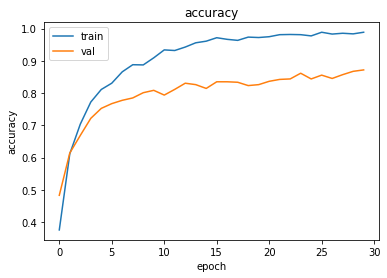

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

# Loss

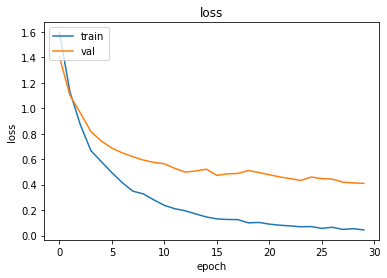

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [ ]:
test_model = tf.keras.models.load_model('/content/garbage_model.h5')

In [ ]:
test_labels = test_datagen.classes
predictions = test_model.predict(test_datagen, steps=259, verbose=1)

259/259 [==============================] - 6s 24ms/step


# Confusion Matrix

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['paper', 'cardboard', 'trash', 'metal', 'glass', 'plastic']

Confusion matrix, without normalization
[[36  0  0  6  0  0]
 [ 0 49  0  0  2  0]
 [ 1  1 39  0  0  1]
 [ 3  0  1 54  0  2]
 [ 0  2  2  1 43  1]
 [ 2  0  0  0  0 13]]


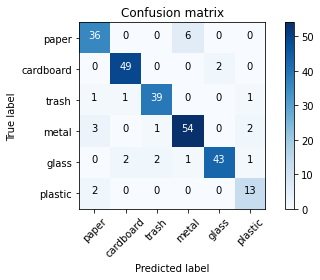

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels)

Normalized confusion matrix
[[0.85714286 0.         0.         0.14285714 0.         0.        ]
 [0.         0.96078431 0.         0.         0.03921569 0.        ]
 [0.02380952 0.02380952 0.92857143 0.         0.         0.02380952]
 [0.05       0.         0.01666667 0.9        0.         0.03333333]
 [0.         0.04081633 0.04081633 0.02040816 0.87755102 0.02040816]
 [0.13333333 0.         0.         0.         0.         0.86666667]]


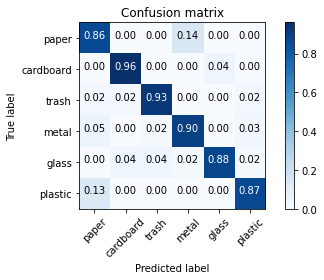

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels, True)

In [ ]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=cm_plot_labels))

Confusion Matrix
[[36  0  0  6  0  0]
 [ 0 49  0  0  2  0]
 [ 1  1 39  0  0  1]
 [ 3  0  1 54  0  2]
 [ 0  2  2  1 43  1]
 [ 2  0  0  0  0 13]]
Classification Report
              precision    recall  f1-score   support

       paper       0.86      0.86      0.86        42
   cardboard       0.94      0.96      0.95        51
       trash       0.93      0.93      0.93        42
       metal       0.89      0.90      0.89        60
       glass       0.96      0.88      0.91        49
     plastic       0.76      0.87      0.81        15

    accuracy                           0.90       259
   macro avg       0.89      0.90      0.89       259
weighted avg       0.91      0.90      0.90       259

